## Implementation of a Decision Tree Classifier from Scratch

This code implements a simple decision tree classifier from scratch without using scikit-learn. It first generates a synthetic dataset with categorical features (Ear Type, Face Type, Whiskers) and a numerical feature (Weight), encoding categorical variables into numerical values. The dataset is then split into training and test sets using `train_test_split`. The decision tree is built recursively by calculating entropy and information gain to determine the best splits. The predict function enables classification of new data points, and compute_accuracy evaluates model performance. Finally, the tree structure is printed for interpretation, and the model accuracy is displayed to assess its effectiveness.

In [63]:
import numpy as np
from sklearn.model_selection import train_test_split

# Feature names and possible values
FEATURE_NAMES = ["Ear Type", "Face Type", "Whiskers", "Weight"]
EAR_TYPES = ["pointy", "floppy"]
FACE_TYPES = ["round", "not round"]
WHISKER_TYPES = ["present", "absent"]

# Generate dataset
def generate_dataset(n_samples=50):
    """Generates a synthetic dataset."""
    ear_types = np.random.choice(EAR_TYPES, n_samples)
    face_types = np.random.choice(FACE_TYPES, n_samples)
    whisker_types = np.random.choice(WHISKER_TYPES, n_samples)
    weights = np.random.uniform(5, 10, n_samples)

    # Simple rule-based labels
    labels = []
    for i in range(n_samples):
        if ear_types[i] == "pointy" and face_types[i] == "round":
            labels.append(1)  # Cat
        elif weights[i] > 8 and whisker_types[i] == "present":
            labels.append(1)
        else:
            labels.append(0)  # Dog/Other
    return np.array([ear_types, face_types, whisker_types, weights]).T, np.array(labels)

# Encode categorical features
def encode_features(X):
    """Encodes categorical features as numerical."""
    encoded_X = np.zeros((X.shape[0], X.shape[1]), dtype=object)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if j == 0:  # Ear Type
                encoded_X[i, j] = 1 if X[i, j] == "pointy" else 0
            elif j == 1:  # Face Type
                encoded_X[i, j] = 1 if X[i, j] == "round" else 0
            elif j == 2:  # Whiskers
                encoded_X[i, j] = 1 if X[i, j] == "present" else 0
            else:  # Weight
                encoded_X[i, j] = float(X[i, j])
    return encoded_X.astype(np.float64)

# Compute entropy
def entropy(y):
    """Calculates entropy to measure dataset purity."""
    if len(y) == 0:
        return 0
    probabilities = np.bincount(y) / len(y)
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log2(probabilities))

# Compute information gain
def information_gain(y_parent, y_left, y_right):
    """Computes the information gain from a dataset split."""
    p_left = len(y_left) / len(y_parent)
    p_right = 1 - p_left
    return entropy(y_parent) - (p_left * entropy(y_left) + p_right * entropy(y_right))

# Find the best split
def best_split(X, y):
    """Find the best feature and threshold to split on."""
    best_feature, best_threshold, best_gain = None, None, -float("inf")
    best_left_idx, best_right_idx = None, None

    for feature_index in range(X.shape[1]):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices

            if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                continue

            gain = information_gain(y, y[left_indices], y[right_indices])
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_index
                best_threshold = threshold
                best_left_idx = left_indices
                best_right_idx = right_indices

    return best_feature, best_threshold, best_left_idx, best_right_idx

# Build the tree recursively
def build_tree(X, y, depth=0, max_depth=None):
    """Recursively build the decision tree."""
    if len(np.unique(y)) == 1 or (max_depth is not None and depth >= max_depth):
        return most_common_label(y)

    feature, threshold, left_idx, right_idx = best_split(X, y)
    if feature is None:
        return most_common_label(y)

    left_subtree = build_tree(X[left_idx], y[left_idx], depth + 1, max_depth)
    right_subtree = build_tree(X[right_idx], y[right_idx], depth + 1, max_depth)

    return (feature, threshold, left_subtree, right_subtree)

# Return most common label
def most_common_label(y):
    """Return the most common label in y."""
    unique_labels, counts = np.unique(y, return_counts=True)
    return unique_labels[np.argmax(counts)]

# Make predictions using the trained decision tree
def predict(tree, X_sample):
    """Predicts the class label for a given sample using the trained decision tree."""
    if not isinstance(tree, tuple):
        return tree  # Leaf node, return class label

    feature, threshold, left_subtree, right_subtree = tree
    if X_sample[feature] <= threshold:
        return predict(left_subtree, X_sample)
    else:
        return predict(right_subtree, X_sample)

# Compute accuracy
def compute_accuracy(tree, X_test, y_test):
    """Computes accuracy of the decision tree model."""
    predictions = np.array([predict(tree, x) for x in X_test])
    accuracy = np.mean(predictions == y_test)
    return accuracy

# Print the decision tree
def print_tree(tree, feature_names, X_data, y_data, depth=0):
    """Recursively prints the decision tree."""
    num_samples = len(y_data)
    sum1 = np.sum(y_data == 1)
    sum0 = np.sum(y_data == 0)
    current_entropy = entropy(y_data)

    if not isinstance(tree, tuple):
        print("  " * depth + f"Leaf: {tree} (Samples: {num_samples}, Vals 01=[{sum0},{sum1}], Entropy: {current_entropy:.4f})")
        return

    feature, threshold, left_subtree, right_subtree = tree

    print("  " * depth + f"[{feature_names[feature]} <= {threshold:.2f}] (Samples: {num_samples}, Vals 01=[{sum0},{sum1}], Entropy: {current_entropy:.4f})")

    left_indices = X_data[:, feature] <= threshold
    right_indices = ~left_indices

    print("  " * depth + "├── Left:")
    print_tree(left_subtree, feature_names, X_data[left_indices], y_data[left_indices], depth + 1)
    print("  " * depth + "└── Right:")
    print_tree(right_subtree, feature_names, X_data[right_indices], y_data[right_indices], depth + 1)

# Generate and preprocess dataset
np.random.seed(42)
X, y = generate_dataset(50)
X_encoded = encode_features(X)

# Train-test split (80-20)
X_train, X_cv, y_train, y_cv = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Build the tree
tree = build_tree(X_train, y_train, max_depth=5)

# Print the optimal decision tree
print("\nOptimal Decision Tree Structure:\n")
print_tree(tree, FEATURE_NAMES, X_train, y_train)

# Compute and print accuracy
accuracy = compute_accuracy(tree, X_cv, y_cv)
print(f"\nModel Accuracy: {accuracy:.4f}")


Optimal Decision Tree Structure:

[Ear Type <= 0.00] (Samples: 40, Vals 01=[26,14], Entropy: 0.9341)
├── Left:
  [Weight <= 7.81] (Samples: 21, Vals 01=[19,2], Entropy: 0.4537)
  ├── Left:
    Leaf: 0 (Samples: 15, Vals 01=[15,0], Entropy: -0.0000)
  └── Right:
    [Whiskers <= 0.00] (Samples: 6, Vals 01=[4,2], Entropy: 0.9183)
    ├── Left:
      Leaf: 0 (Samples: 4, Vals 01=[4,0], Entropy: -0.0000)
    └── Right:
      Leaf: 1 (Samples: 2, Vals 01=[0,2], Entropy: -0.0000)
└── Right:
  [Face Type <= 0.00] (Samples: 19, Vals 01=[7,12], Entropy: 0.9495)
  ├── Left:
    [Weight <= 8.12] (Samples: 9, Vals 01=[7,2], Entropy: 0.7642)
    ├── Left:
      Leaf: 0 (Samples: 6, Vals 01=[6,0], Entropy: -0.0000)
    └── Right:
      [Whiskers <= 0.00] (Samples: 3, Vals 01=[1,2], Entropy: 0.9183)
      ├── Left:
        Leaf: 0 (Samples: 1, Vals 01=[1,0], Entropy: -0.0000)
      └── Right:
        Leaf: 1 (Samples: 2, Vals 01=[0,2], Entropy: -0.0000)
  └── Right:
    Leaf: 1 (Samples: 10, Vals 01

## Building a Decision Tree Classifier Using Scikit-Learn

This code implements a decision tree classifier using **Scikit-Learn** to classify animals based on their physical features. It first generates a synthetic dataset where categorical attributes (Ear Type, Face Type, and Whiskers) are encoded numerically using LabelEncoder, while Weight remains a numerical feature. The dataset is then split into training (80%) and test (20%) sets using `train_test_split`. A DecisionTreeClassifier with a maximum depth of 5 is trained on the dataset, and predictions are made on the test set. Finally, model performance is evaluated using accuracy_score, and the trained decision tree's structure is displayed using `tree.export_text`, allowing for easy interpretation of the decision rules.

Model Accuracy: 0.9000


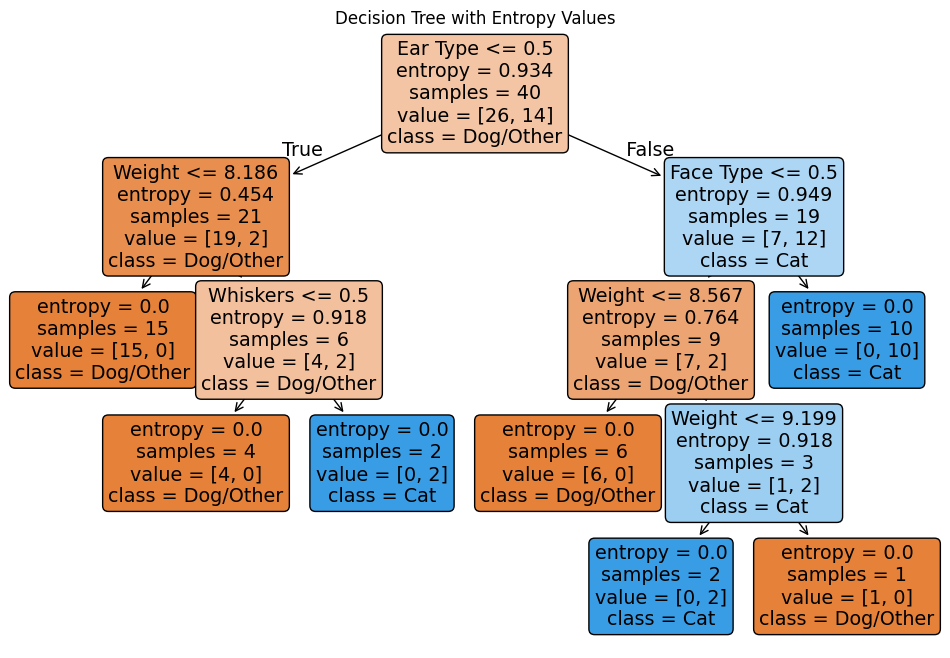

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Feature names and possible values
FEATURE_NAMES = ["Ear Type", "Face Type", "Whiskers", "Weight"]
EAR_TYPES = ["pointy", "floppy"]
FACE_TYPES = ["round", "not round"]
WHISKER_TYPES = ["present", "absent"]

# Generate dataset
def generate_dataset(n_samples=50):
    """Generates a synthetic dataset."""
    np.random.seed(42)
    ear_types = np.random.choice(EAR_TYPES, n_samples)
    face_types = np.random.choice(FACE_TYPES, n_samples)
    whisker_types = np.random.choice(WHISKER_TYPES, n_samples)
    weights = np.random.uniform(5, 10, n_samples)

    # Simple rule-based labels
    labels = []
    for i in range(n_samples):
        if ear_types[i] == "pointy" and face_types[i] == "round":
            labels.append(1)  # Cat
        elif weights[i] > 8 and whisker_types[i] == "present":
            labels.append(1)
        else:
            labels.append(0)  # Dog/Other

    data = pd.DataFrame({
        "Ear Type": ear_types,
        "Face Type": face_types,
        "Whiskers": whisker_types,
        "Weight": weights,
        "Label": labels
    })

    return data

# Encode categorical features
def encode_features(data):
    """Encodes categorical features into numerical values."""
    label_encoders = {}
    for col in ["Ear Type", "Face Type", "Whiskers"]:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le  # Store encoder for future use
    return data, label_encoders

# Generate and preprocess dataset
data = generate_dataset(50)
data, label_encoders = encode_features(data)

# Split features and target
X = data[["Ear Type", "Face Type", "Whiskers", "Weight"]]
y = data["Label"]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier with ENTROPY
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Plot the decision tree with entropy values
plt.figure(figsize=(12, 8))
tree_plot = plot_tree(clf, feature_names=FEATURE_NAMES, class_names=["Dog/Other", "Cat"],
                      filled=True, rounded=True, impurity=True)

plt.title("Decision Tree with Entropy Values")
plt.show()


In [61]:
# Create a Pandas DataFrame
df_train = pd.DataFrame(X_train, columns=FEATURE_NAMES)
df_train['label'] = y_train

# Export the DataFrame to a CSV file
csv_file_path = 'train_data.csv'
df_train.to_csv(csv_file_path, index=False)

print(f"X_train and y_train exported to '{csv_file_path}'")


def entropy_cal(p):
  H = -p*np.log2(p) - (1-p)*np.log2((1-p))
  return H

print(entropy_cal(14/40))

X_train and y_train exported to 'train_data.csv'
0.934068055375491


## Random Forest

This Jupyter Notebook script implements a Random Forest classifier to classify animals as either "Cat" or "Dog/Other" based on four features: Ear Type, Face Type, Whiskers, and Weight. The dataset is synthetically generated, with categorical features being encoded into numerical values for processing. The dataset is then split into training and test sets, and a Random Forest model with 10 decision trees is trained using entropy as the splitting criterion. Predictions are made in two ways: (1) using the built-in `predict()` method of the Random Forest and (2) by aggregating individual tree predictions via majority voting to demonstrate ensemble learning. The script then visualizes all decision trees using subplots, dynamically adjusting the grid size based on the number of trees. Finally, a voting table is displayed, showing how each tree contributes to the final decision. The accuracy of both methods is printed, providing insights into the effectiveness of ensemble learning.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: U

Random Forest Model Accuracy (Majority): 0.9000
Random Forest Model Accuracy: 0.9000


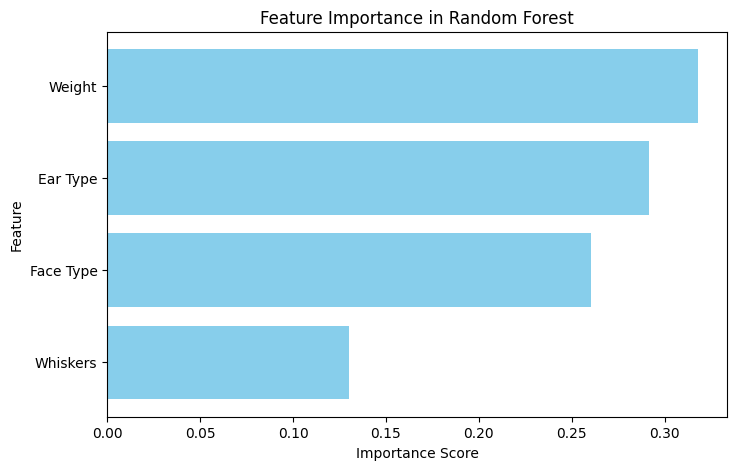

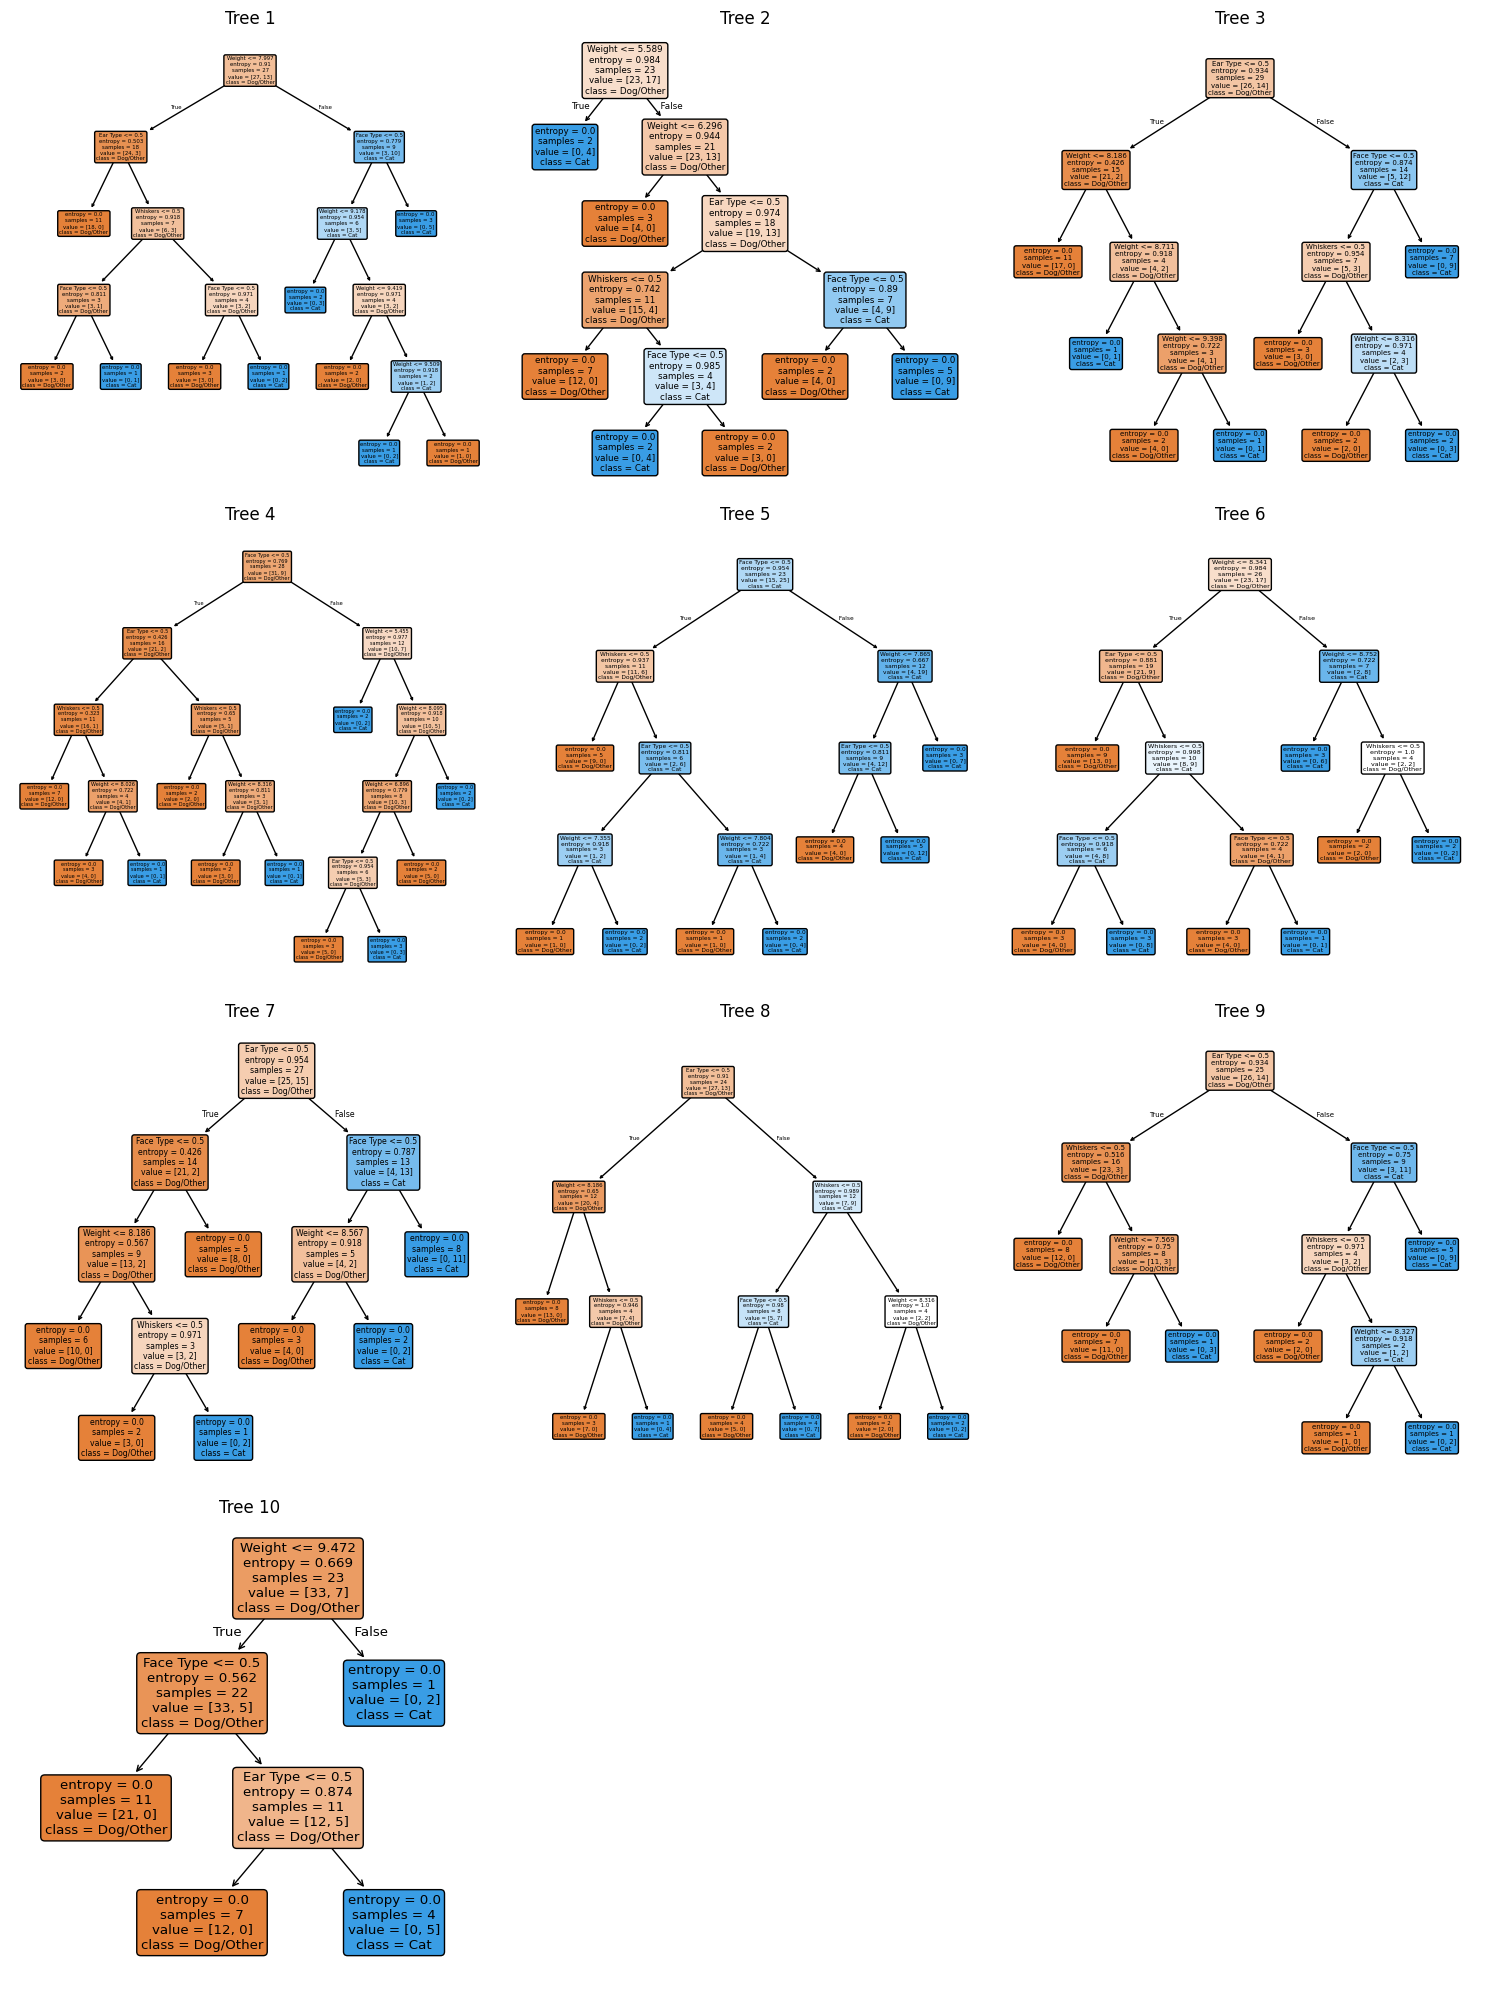


Random Forest Voting Table:


,Tree 1,Tree 2,Tree 3,Tree 4,Tree 5,Tree 6,Tree 7,Tree 8,Tree 9,Tree 10,Majority Vote,Actual Label
0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1
4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1
9,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil  # Import ceil function
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Feature names and possible values
FEATURE_NAMES = ["Ear Type", "Face Type", "Whiskers", "Weight"]
EAR_TYPES = ["pointy", "floppy"]
FACE_TYPES = ["round", "not round"]
WHISKER_TYPES = ["present", "absent"]

# Generate dataset
def generate_dataset(n_samples=50):
    """Generates a synthetic dataset."""
    np.random.seed(42)
    ear_types = np.random.choice(EAR_TYPES, n_samples)
    face_types = np.random.choice(FACE_TYPES, n_samples)
    whisker_types = np.random.choice(WHISKER_TYPES, n_samples)
    weights = np.random.uniform(5, 10, n_samples)

    # Simple rule-based labels
    labels = []
    for i in range(n_samples):
        if ear_types[i] == "pointy" and face_types[i] == "round":
            labels.append(1)  # Cat
        elif weights[i] > 8 and whisker_types[i] == "present":
            labels.append(1)
        else:
            labels.append(0)  # Dog/Other

    data = pd.DataFrame({
        "Ear Type": ear_types,
        "Face Type": face_types,
        "Whiskers": whisker_types,
        "Weight": weights,
        "Label": labels
    })

    return data

# Encode categorical features
def encode_features(data):
    """Encodes categorical features into numerical values."""
    label_encoders = {}
    for col in ["Ear Type", "Face Type", "Whiskers"]:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le  # Store encoder for future use
    return data, label_encoders

# Generate and preprocess dataset
data = generate_dataset(50)
data, label_encoders = encode_features(data)

# Split features and target
X = data[["Ear Type", "Face Type", "Whiskers", "Weight"]]
y = data["Label"]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
n_trees = 10
rf_clf = RandomForestClassifier(n_estimators=n_trees, criterion="entropy", max_depth=5, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Make predictions from all trees
tree_predictions = np.array([tree.predict(X_test) for tree in rf_clf.estimators_])

# Compute majority vote (mode of predictions)
final_predictions = np.round(tree_predictions.mean(axis=0))  # Majority voting

# Compute accuracy
accuracy_mjr = accuracy_score(y_test, final_predictions)
print(f"Random Forest Model Accuracy (Majority): {accuracy_mjr:.4f}")

accuracy_pred = accuracy_score(y_test, y_pred)
print(f"Random Forest Model Accuracy: {accuracy_pred:.4f}")

# Feature Importance Visualization
importances = rf_clf.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": FEATURE_NAMES, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in Random Forest")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

# Determine grid size dynamically
n_cols = min(3, n_trees)  # Maximum 3 columns per row
n_rows = ceil(n_trees / n_cols)  # Calculate number of rows

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5))

# Flatten axes if n_trees < n_cols * n_rows
axes = np.array(axes).reshape(-1)

# Plot each decision tree in the Random Forest
for i in range(n_trees):
    plot_tree(rf_clf.estimators_[i], feature_names=FEATURE_NAMES, class_names=["Dog/Other", "Cat"],
              filled=True, rounded=True, impurity=True, ax=axes[i])
    axes[i].set_title(f"Tree {i+1}")

# Remove empty subplots if n_trees is not a perfect fit
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Create a DataFrame to visualize the votes
predictions_df = pd.DataFrame(tree_predictions.T, columns=[f"Tree {i+1}" for i in range(n_trees)])
predictions_df["Majority Vote"] = final_predictions
predictions_df["Actual Label"] = y_test.values

# Display voting table in Jupyter Notebook
from IPython.display import display

print("\nRandom Forest Voting Table:")
display(predictions_df.head(10))  # Show the first 10 rows


## XGBoost

This script implements an XGBoost classification model to distinguish between "Cat" and "Dog/Other" based on four key features: Ear Type, Face Type, Whiskers, and Weight. It begins by generating a synthetic dataset, encoding categorical features numerically, and splitting the data into training and test sets (80-20 split). The model is trained using 100 decision trees, with a maximum depth of 5 and a learning rate of 0.05, optimizing for binary classification. After training, predictions are made on the test set, and the model's accuracy is computed. Additionally, the script visualizes the feature importance to understand which attributes contribute the most to the classification. The final section, currently commented out, contains an option to visualize all individual decision trees in the XGBoost model using subplots.

XGBoost Model Accuracy: 0.9000


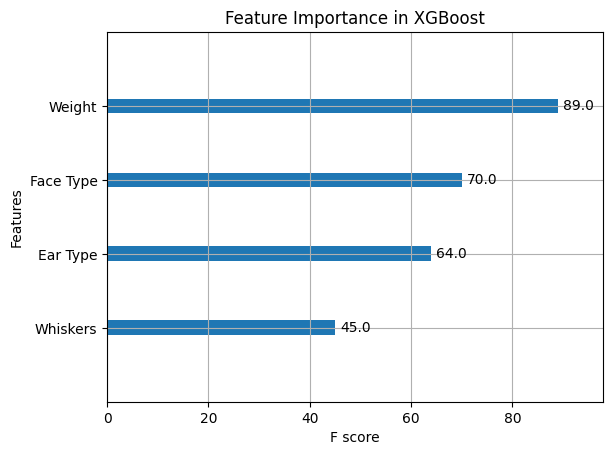

'# Determine grid size dynamically\nn_cols = min(3, n_trees)  # Max 3 columns per row\nn_rows = ceil(n_trees / n_cols)  # Compute number of rows\n\n# Create subplots\nfig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5))\n\n# Flatten axes array if needed\naxes = np.array(axes).flatten()\n\n# Plot individual trees from XGBoost\nfor i in range(n_trees):\n    xgb.plot_tree(xgb_clf, num_trees=i, ax=axes[i])  # Fix: use xgboost.plot_tree\n    axes[i].set_title(f"XGBoost Tree {i+1}")\n\n# Remove extra empty subplots if n_trees is not a perfect fit\nfor j in range(i + 1, len(axes)):\n    fig.delaxes(axes[j])\n\nplt.tight_layout()\nplt.show()'

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil  # Import ceil function
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Feature names and possible values
FEATURE_NAMES = ["Ear Type", "Face Type", "Whiskers", "Weight"]
EAR_TYPES = ["pointy", "floppy"]
FACE_TYPES = ["round", "not round"]
WHISKER_TYPES = ["present", "absent"]

# Generate dataset
def generate_dataset(n_samples=50):
    """Generates a synthetic dataset."""
    np.random.seed(42)
    ear_types = np.random.choice(EAR_TYPES, n_samples)
    face_types = np.random.choice(FACE_TYPES, n_samples)
    whisker_types = np.random.choice(WHISKER_TYPES, n_samples)
    weights = np.random.uniform(5, 10, n_samples)

    # Simple rule-based labels
    labels = []
    for i in range(n_samples):
        if ear_types[i] == "pointy" and face_types[i] == "round":
            labels.append(1)  # Cat
        elif weights[i] > 8 and whisker_types[i] == "present":
            labels.append(1)
        else:
            labels.append(0)  # Dog/Other

    data = pd.DataFrame({
        "Ear Type": ear_types,
        "Face Type": face_types,
        "Whiskers": whisker_types,
        "Weight": weights,
        "Label": labels
    })

    return data

# Encode categorical features
def encode_features(data):
    """Encodes categorical features into numerical values."""
    label_encoders = {}
    for col in ["Ear Type", "Face Type", "Whiskers"]:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le  # Store encoder for future use
    return data, label_encoders

# Generate and preprocess dataset
data = generate_dataset(50)
data, label_encoders = encode_features(data)

# Split features and target
X = data[["Ear Type", "Face Type", "Whiskers", "Weight"]]
y = data["Label"]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Classifier
n_trees = 100
xgb_clf = xgb.XGBClassifier(n_estimators=n_trees, max_depth=5, learning_rate=0.05, objective='binary:logistic', random_state=42)
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Compute accuracy
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy_xgb:.4f}")

# Plot feature importance
xgb.plot_importance(xgb_clf)
plt.title("Feature Importance in XGBoost")
plt.show()

"""# Determine grid size dynamically
n_cols = min(3, n_trees)  # Max 3 columns per row
n_rows = ceil(n_trees / n_cols)  # Compute number of rows

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 5))

# Flatten axes array if needed
axes = np.array(axes).flatten()

# Plot individual trees from XGBoost
for i in range(n_trees):
    xgb.plot_tree(xgb_clf, num_trees=i, ax=axes[i])  # Fix: use xgboost.plot_tree
    axes[i].set_title(f"XGBoost Tree {i+1}")

# Remove extra empty subplots if n_trees is not a perfect fit
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()"""